In [ ]:
#!/usr/bin/env python3.
# coding: utf-8 -*-

"""
Created on Thu Mar  3 08:40:02 2022.

@author: AnahiRomo

"""
! pip install tbats
! pip install pmdarima
! pip install statsmodels

# librerías de manipulación de datos
import pandas as pd
import numpy as np

# librerías de modelos
import pmdarima as pm
import statsmodels as sm
import statsmodels.api as sm_api

from statsmodels.tsa.stattools import adfuller
from pmdarima.arima.utils import ndiffs
from tbats import TBATS

# para instalar https://www.statsmodels.org/dev/install.html
# para consultar documentación https://www.statsmodels.org/
# pmdarima https://alkaline-ml.com/pmdarima/index.html  pip install pmdarima
# pip install tbats / https://pypi.org/project/tbats/
# documentación en: https://github.com/intive-DataScience/tbats
# DOS ARTÍCULOS PARA CONSULTAR DONDE APLICAN TBATS
# https://medium.com/intive-developers/forecasting-time-series-with-multiple-seasonalities-using-tbats-in-python-398a00ac0e8a
#https://www.fcecon.unr.edu.ar/web-nueva/sites/default/files/u16/Decimocuartas/blacona_andreozzi_modelos_para_series_de_tiempo.pdf


# librerías de visualización
import matplotlib.pyplot as plt
from pylab import rcParams

import warnings  # para ignorar los warnings
warnings.filterwarnings('ignore')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 KB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 16.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# función que aplica el test de Dickey Fuller para determinar estacionariedad

def dickey_fuller(serie):
    """Realiza prueba Dickey-Fuller."""
    # hacemos el test
    dftest = adfuller(serie, autolag='AIC')
    tstat = dftest[0]
    pvalue = dftest[1]
    cvalues = dftest[4]
    print('\n')
    print('Resultado de la prueba Dickey-Fuller')
    print("------------------")
    print("Estadística de prueba\t", tstat)
    print("p-value\t\t\t", pvalue)
    print("------------------")
    print("Valores críticos (la estadística de prueba debe ser MENOR)")

    clevels = [10, 5, 1]
    for clevel in clevels:
        conf = 100 - clevel
        cval = cvalues[f'{clevel}%']
        if tstat < cval:
            comp = ">"
            verdict = "PASA: ES ESTACIONARIA"
        else:
            comp = "<"
            verdict = "FALLA: NO ES ESTACIONARIA"
        print(f"Confianza {conf}%\t\t{cval} {comp} {tstat}... {verdict}")

    return


In [ ]:
from google.colab import files

files.upload()

In [ ]:
energia = pd.read_csv('mes.csv', parse_dates=True, index_col='Momento')
print(energia.columns)
energia

Index(['Eólico', 'Fotovoltaico', 'Bioenergías', 'Hidráulico',
       '% Demanda Abastecida'],
      dtype='object')


,Eólico,Fotovoltaico,Bioenergías,Hidráulico,% Demanda Abastecida
Momento,,,,,
2022-02-01 00:05:00,2644.78,0.0,139.57,173.67,16.73
2022-02-01 00:10:00,2629.13,0.0,139.58,174.11,16.75
2022-02-01 00:15:00,2653.42,0.0,139.78,173.93,16.95
2022-02-01 00:20:00,2671.34,0.0,139.42,173.91,17.15
2022-02-01 00:25:00,2605.95,0.0,139.06,173.69,16.96
...,...,...,...,...,...
2022-02-28 23:40:00,1513.73,0.0,122.16,139.04,11.81
2022-02-28 23:45:00,1514.59,0.0,121.92,138.53,11.94
2022-02-28 23:50:00,1488.35,0.0,122.20,139.55,11.88


In [ ]:
energia.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8064 entries, 2022-02-01 00:05:00 to 2022-03-01 00:00:00
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Eólico                8064 non-null   float64
 1   Fotovoltaico          8064 non-null   float64
 2   Bioenergías           8064 non-null   float64
 3   Hidráulico            8064 non-null   float64
 4   % Demanda Abastecida  8064 non-null   float64
dtypes: float64(5)
memory usage: 378.0 KB


In [ ]:
energia.describe()

,Eólico,Fotovoltaico,Bioenergías,Hidráulico,% Demanda Abastecida
count,8064.000000,8064.000000,8064.000000,8064.000000,8064.000000
mean,1582.250727,365.191400,134.274803,166.079498,13.486062
std,537.768371,402.492514,7.731470,14.839639,3.768820
min,167.020000,0.000000,89.670000,130.810000,4.580000
25%,1256.627500,0.000000,131.617500,156.830000,10.810000
50%,1594.290000,63.400000,135.630000,163.440000,13.250000
75%,1932.832500,818.137500,139.220000,178.692500,16.140000
max,2791.870000,996.950000,148.190000,200.500000,25.010000


In [ ]:
fv = energia['Fotovoltaico'].copy()
fv

Momento
2022-02-01 00:05:00    0.0
2022-02-01 00:10:00    0.0
2022-02-01 00:15:00    0.0
2022-02-01 00:20:00    0.0
2022-02-01 00:25:00    0.0
                      ... 
2022-02-28 23:40:00    0.0
2022-02-28 23:45:00    0.0
2022-02-28 23:50:00    0.0
2022-02-28 23:55:00    0.0
2022-03-01 00:00:00    0.0
Name: Fotovoltaico, Length: 8064, dtype: float64

In [ ]:
fv = fv.resample('5T').sum()     # remuestrea la serie cada 5 minutos
fv

Momento
2022-02-01 00:05:00    0.0
2022-02-01 00:10:00    0.0
2022-02-01 00:15:00    0.0
2022-02-01 00:20:00    0.0
2022-02-01 00:25:00    0.0
                      ... 
2022-02-28 23:40:00    0.0
2022-02-28 23:45:00    0.0
2022-02-28 23:50:00    0.0
2022-02-28 23:55:00    0.0
2022-03-01 00:00:00    0.0
Freq: 5T, Name: Fotovoltaico, Length: 8064, dtype: float64

<Axes: xlabel='Momento'>

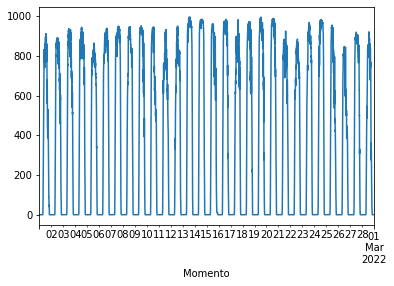

In [ ]:
fv.plot()


<Axes: xlabel='Momento'>

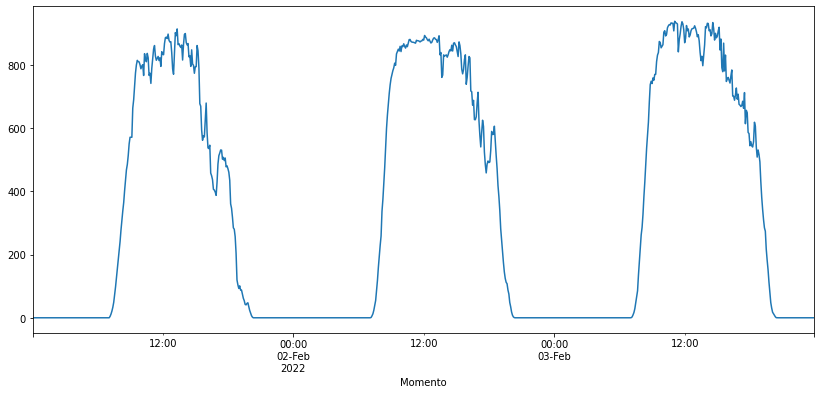

In [ ]:
# más detalle
fv['2022-02-01':'2022-02-03'].plot()

In [ ]:
#  apliquemos la prueba de Dickey-Fuller

dickey_fuller(fv)

# ENTONCES NUESTRA SERIE ES ESTACIONARIA




Resultado de la prueba Dickey-Fuller
------------------
Estadística de prueba	 -9.812727372462492
p-value			 5.601090297612881e-17
------------------
Valores críticos (la estadística de prueba debe ser MENOR)
Confianza 90%		-2.5669616251324037 > -9.812727372462492... PASA: ES ESTACIONARIA
Confianza 95%		-2.861900003473685 > -9.812727372462492... PASA: ES ESTACIONARIA
Confianza 99%		-3.4311646191336043 > -9.812727372462492... PASA: ES ESTACIONARIA


In [ ]:
# usando auto_arima buscaremos los parámetros para el modelo ARIMA
model_1 = pm.auto_arima(fv.values, start_p=1, start_q=1,
                      test='adf',
                      max_p=3, max_q=3,
                      m=1,
                      d=None,
                      seasonal=False,
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model_1.summary())    # Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
                            # Total fit time: 100.454 seconds

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=73316.493, Time=0.77 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=124459.971, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=113628.954, Time=3.46 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=72213.926, Time=3.29 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.39 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=72213.384, Time=3.75 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.51 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=8.81 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=72221.373, Time=5.97 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=72202.002, Time=18.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=72171.056, Time=5.17 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=73314.269, Time=2.41 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=7289

In [ ]:
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 8064
Model:               SARIMAX(2, 0, 1)   Log Likelihood              -36080.528
Date:                Thu, 16 Mar 2023   AIC                          72171.056
Time:                        23:11:37   BIC                          72206.031
Sample:                             0   HQIC                         72183.023
                               - 8064                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4031      0.156      2.578      0.010       0.097       0.710
ar.L1          1.9554      0.005    416.124      0.000       1.946       1.965
ar.L2         -0.9565      0.005   -205.094      0.000      -0.966      -0.947
ma.L1         -0.8164      0.007   -115.351      0.000      -0.830      -0.802
sigma2       450.2671      2.433    185.077      0.000     445.499     455.035
===================================================================================
Ljung-Box (L1) (Q):                   2.43   Jarque-Bera (JB):            106273.77
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                            -0.63
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

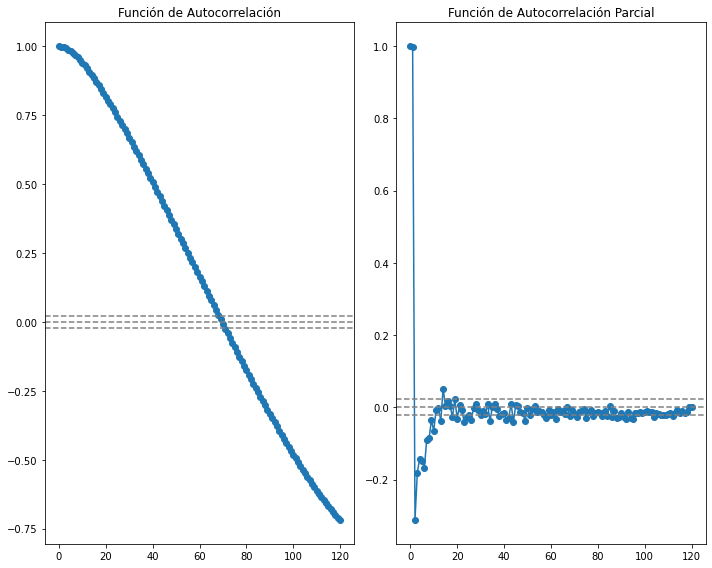

In [ ]:
#%%  calculemos la autocorrelación de la serie

autocor = sm_api.tsa.acf(fv, nlags = 12)
parcial = sm_api.tsa.pacf(fv, nlags = 12, method = 'ols')

rcParams['figure.figsize'] = 10, 8
# Plot ACF:
plt.subplot(121)
plt.plot(autocor,"-o")
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(fv)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(fv)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación')

# Plot PACF:
plt.subplot(122)
plt.plot(parcial,"-o")
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(fv)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(fv)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial')
plt.tight_layout()

# sale p = 2, sugiere q = 1

In [ ]:
# ADF Test: Indica la cantidad de diferenciaciones p/ 'estacionarizar' serie

ndiffs(fv, test = 'adf')

# sale d = 0

0

In [ ]:
#%%   ahora aplicamos ARIMA
# OJO ACÁ: hay varias cosas a prestar atención

fv.squeeze()  # con esto nos aseguramos que pasamos a Serie

# invocamos el modelo, order = (p, d, q) dice qué tipo de modelo se le pide
# p es el orden del modelo autoregresivo, q el orden del modelo de media móvil
# d: la cantidad de veces q se diferencia la serie para q sea 'débilmente'
# estacionaria
modelo = sm.tsa.arima.model.ARIMA(fv, order = (2, 0, 1))

resultados = modelo.fit()

pronostico = resultados.fittedvalues
print(type(pronostico))
pronostico.head(290)

<class 'pandas.core.series.Series'>


Momento
2022-02-01 00:05:00    365.187523
2022-02-01 00:10:00      0.632834
2022-02-01 00:15:00      0.822615
2022-02-01 00:20:00      1.000927
2022-02-01 00:25:00      1.165483
                          ...    
2022-02-01 23:50:00      2.211718
2022-02-01 23:55:00      2.211954
2022-02-02 00:00:00      2.212147
2022-02-02 00:05:00      2.212304
2022-02-02 00:10:00      2.212433
Freq: 5T, Length: 290, dtype: float64

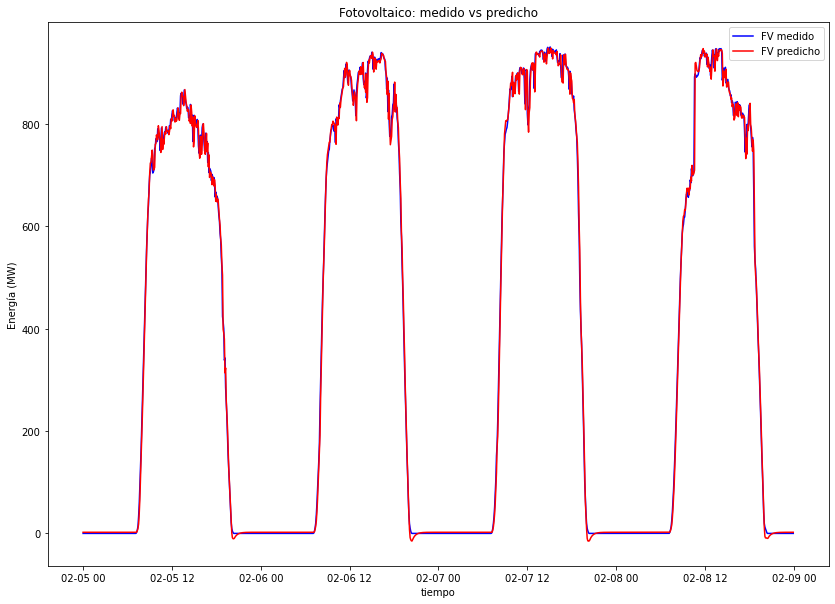

In [ ]:
#%%    graficamos la serie y el ajuste obtenido

plt.figure(figsize = (14, 10))
plt.plot(energia['Fotovoltaico']['2022-02-05':'2022-02-08'],
         label= 'FV medido',
         color = 'blue')
plt.plot(pronostico['2022-02-05':'2022-02-08'],
         label = 'FV predicho',
         color = 'red')
plt.legend(loc = 'best')
plt.xlabel('tiempo')
plt.ylabel('Energía (MW)')
plt.title('Fotovoltaico: medido vs predicho')
plt.show()

In [ ]:
print(resultados.summary())   # los parámetros que obtiene el modelo

                               SARIMAX Results                                
Dep. Variable:           Fotovoltaico   No. Observations:                 8064
Model:                 ARIMA(2, 0, 1)   Log Likelihood              -36080.531
Date:                Thu, 16 Mar 2023   AIC                          72171.062
Time:                        23:13:19   BIC                          72206.037
Sample:                    02-01-2022   HQIC                         72183.029
                         - 03-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        365.1875     76.117      4.798      0.000     216.001     514.374
ar.L1          1.9554      0.005    416.139      0.000       1.946       1.965
ar.L2         -0.9566      0.005   -205.101      0.0

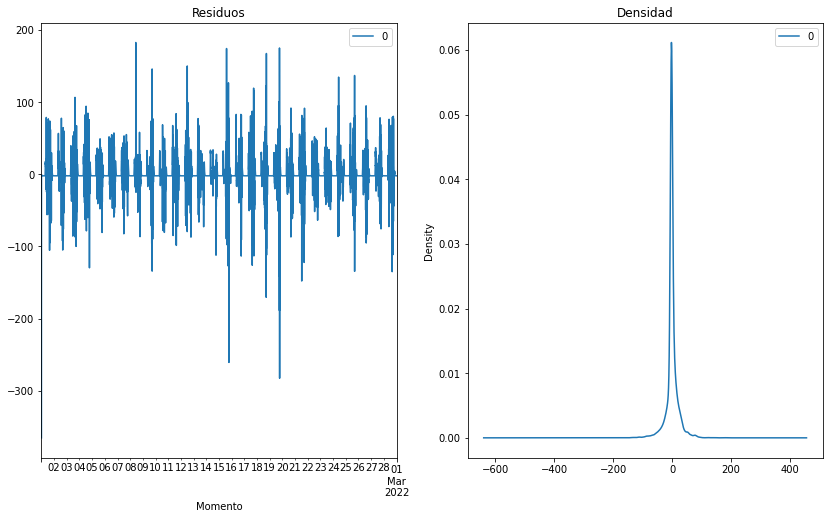

In [ ]:
# Plotear errores residuales, es bueno si están en promedio cerca de 0

residuos = pd.DataFrame(resultados.resid)

rcParams['figure.figsize'] = 14, 8
fig, ax = plt.subplots(1,2)
residuos.plot(title="Residuos", ax=ax[0])
residuos.plot(kind='kde', title='Densidad', ax=ax[1])
plt.show()


In [ ]:
#%% ahora vamos a hacer un pronóstico sobre nuestra serie:
# VALIDACIÓN CRUZADA FUERA DE TIEMPO

# creo conjto de Training y Test, 80% training, 20% testing
# acá no se hace elección aleatoria de las mediciones porque hay que respetar
# el orden temporal

train = fv[:'2022-02-23 00:00']   # 80% sobre el rango de fechas
test = fv['2022-02-23 00:05':]

#%%
pronosticador = sm.tsa.arima.model.ARIMA(train, order = (2, 0, 1))

resulta = pronosticador.fit()


In [ ]:
#%%   # predice
y_pred = resulta.get_forecast(steps = 24*12*6)  #1728 pasos

conf = y_pred.conf_int(alpha = 0.05)  # 95% de confianza
test.index = pd.date_range(start = '2022-02-23 00:05', end = '2022-03-01',
                           freq = '5T')
y_pred.index = test.index
type(y_pred)

statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper

In [ ]:
pronosticado = y_pred.predicted_mean
pronosticado.index = test.index
abajo = conf['lower Fotovoltaico']
arriba = conf['upper Fotovoltaico']
#%%
print(pronosticado.shape)
#%%
print(abajo.shape)
#%%
print(arriba.shape)
#%%
pronosticado.head(150)


(1728,)
(1728,)
(1728,)


2022-02-23 00:05:00      2.228914
2022-02-23 00:10:00      4.776275
2022-02-23 00:15:00      7.624675
2022-02-23 00:20:00     10.757158
2022-02-23 00:25:00     14.157216
                          ...    
2022-02-23 12:10:00    386.457710
2022-02-23 12:15:00    386.151787
2022-02-23 12:20:00    385.843038
2022-02-23 12:25:00    385.531944
2022-02-23 12:30:00    385.218965
Freq: 5T, Name: predicted_mean, Length: 150, dtype: float64

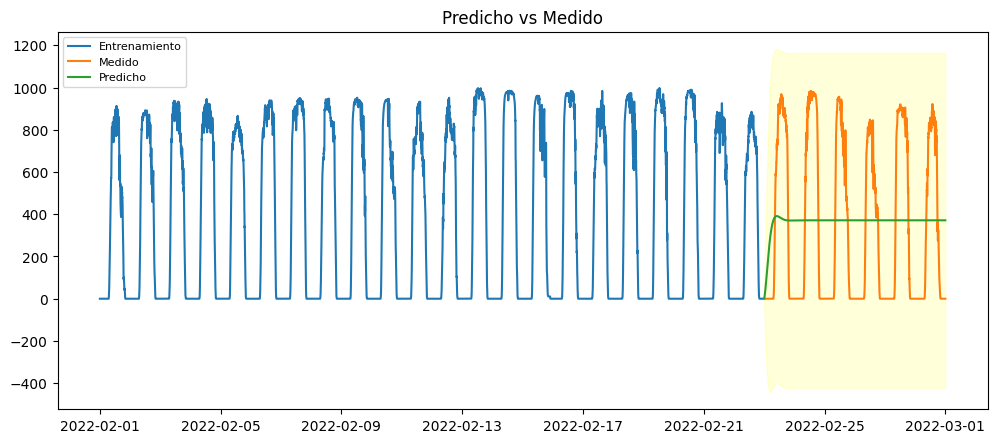

In [ ]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='Entrenamiento')
plt.plot(test, label='Medido')
plt.plot(pronosticado, label='Predicho')
plt.fill_between(abajo.index, abajo, arriba, color='yellow', alpha=.15)
plt.title('Predicho vs Medido')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Vemos que el pronóstico es malo, lo que indica que tendríamos que considerar
# usar un modelo que ajuste la parte estacional de la serie


<class 'statsmodels.tsa.seasonal.DecomposeResult'>
<class 'pandas.core.series.Series'>


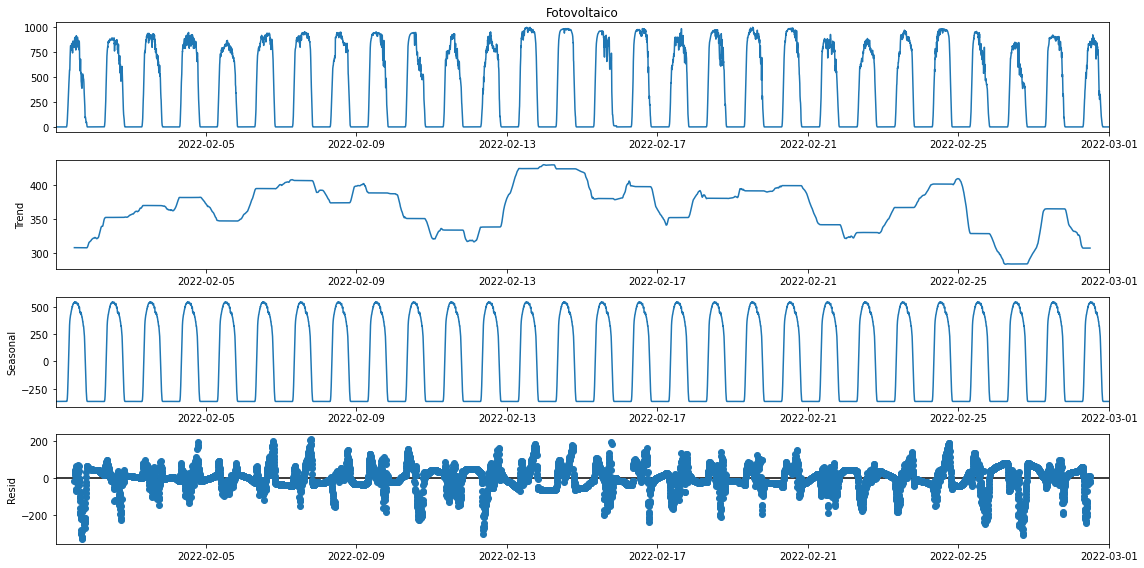

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
# hagamos un 'decompose' a ver qué da...
descomp = seasonal_decompose(fv, model = 'additive',period = 1*24*12,two_sided = True )

print(type(descomp))
residuos = descomp.resid
print(type(residuos))

rcParams['figure.figsize'] = 16, 8
fig = descomp.plot()
#plt.savefig('descomp.png', dpi = 300)


In [ ]:
#     ahora usamos TBATS     DEMORA 5.5 MINUTOS APROX

estimador = TBATS(seasonal_periods = [288],
                  use_arma_errors = False,
                  use_box_cox = False)
# steps es la cantidad de mediciones en un periodo: 1 día = 1*24 h* 12 mediciones/h

modelo_tbats = estimador.fit(train)

pronostico_tbats = modelo_tbats.forecast(steps = 1728)  # 6 días = 6*24*12

print(type(pronostico_tbats) )     # es un array de numpy, hay que pasarlo a serie
tbats = pd.Series(pronostico_tbats)
tbats.index = test.index    # le ponemos las fechas de medición como índice
tbats

<class 'numpy.ndarray'>


2022-02-23 00:05:00    -1.198336
2022-02-23 00:10:00    -2.449491
2022-02-23 00:15:00    -3.625185
2022-02-23 00:20:00    -4.637637
2022-02-23 00:25:00    -5.410701
                         ...    
2022-02-28 23:40:00    15.427555
2022-02-28 23:45:00    14.616917
2022-02-28 23:50:00    13.469240
2022-02-28 23:55:00    12.053325
2022-03-01 00:00:00    10.451813
Freq: 5T, Length: 1728, dtype: float64

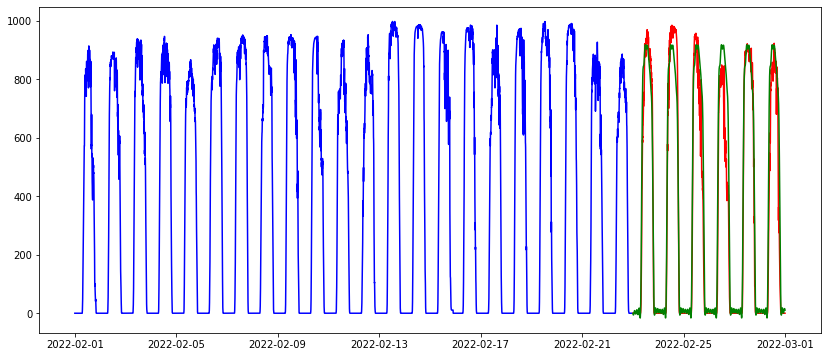

In [ ]:
rcParams['figure.figsize'] = 14, 6
plt.plot(train, c = 'blue', label = 'Train')
plt.plot(test, c = 'red', label = 'Test')
plt.plot(tbats, c = 'green', label = 'Pronóstico')
plt.show()

In [ ]:
#%%   MIREMOS LOS RESULTADOS DEL MODELO

print(modelo_tbats.summary())
# Time series analysis
print(modelo_tbats.y_hat) # in sample prediction
print(modelo_tbats.resid) # in sample residuals
print(modelo_tbats.aic)

# Reading model parameters
print(modelo_tbats.params.alpha)
print(modelo_tbats.params.beta)
print(modelo_tbats.params.x0)
print(modelo_tbats.params.components.use_box_cox)
print(modelo_tbats.params.components.seasonal_harmonics)


Use Box-Cox: False
Use trend: True
Use damped trend: True
Seasonal periods: [288.]
Seasonal harmonics [10]
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): 1.032313
Trend (Beta): -0.048076
Damping Parameter (Phi): 0.955509
Seasonal Parameters (Gamma): [-4.77129886e-07 -3.17201961e-09]
AR coefficients []
MA coefficients []
Seed vector [ 3.85578464e+02 -4.07456412e-01 -4.90247510e+02  9.55241166e+01
  2.54145574e+01  2.44008241e+00  2.86016466e+01 -3.61591248e+01
 -1.67364542e+01  2.88611823e+01 -1.42912672e-01 -5.91659100e+00
 -2.01470788e+02  7.44460086e+01  1.08156470e+02 -6.50415416e+01
 -3.51662442e+01  2.64548346e+01 -9.63631132e-01  5.78115788e+00
  6.32397521e+00 -1.69453649e+01]

AIC 93255.724041
[16.82812868 -1.83668619 -1.24070919 ... -0.49324622 -0.80140718
 -1.0404939 ]
[-16.82812868   1.83668619   1.24070919 ...   0.49324622   0.80140718
   1.0404939 ]
93255.72404082102
1.0323130302626036
-0.04807626969889525
[ 3.85578464e+02 -4.07456412e-01 -4.90247510e+02  9.55241166e+01
  2

In [ ]:
modelo_tbats.summary()

'Use Box-Cox: False\nUse trend: True\nUse damped trend: True\nSeasonal periods: [288.]\nSeasonal harmonics [10]\nARMA errors (p, q): (0, 0)\nSmoothing (Alpha): 1.032313\nTrend (Beta): -0.048076\nDamping Parameter (Phi): 0.955509\nSeasonal Parameters (Gamma): [-4.77129886e-07 -3.17201961e-09]\nAR coefficients []\nMA coefficients []\nSeed vector [ 3.85578464e+02 -4.07456412e-01 -4.90247510e+02  9.55241166e+01\n  2.54145574e+01  2.44008241e+00  2.86016466e+01 -3.61591248e+01\n -1.67364542e+01  2.88611823e+01 -1.42912672e-01 -5.91659100e+00\n -2.01470788e+02  7.44460086e+01  1.08156470e+02 -6.50415416e+01\n -3.51662442e+01  2.64548346e+01 -9.63631132e-01  5.78115788e+00\n  6.32397521e+00 -1.69453649e+01]\n\nAIC 93255.724041'



Resultado de la prueba Dickey-Fuller
------------------
Estadística de prueba	 -6.288298302309365
p-value			 3.6518296021706415e-08
------------------
Valores críticos (la estadística de prueba debe ser MENOR)
Confianza 90%		-2.566961505861297 > -6.288298302309365... PASA: ES ESTACIONARIA
Confianza 95%		-2.861899779410679 > -6.288298302309365... PASA: ES ESTACIONARIA
Confianza 99%		-3.4311641120523326 > -6.288298302309365... PASA: ES ESTACIONARIA


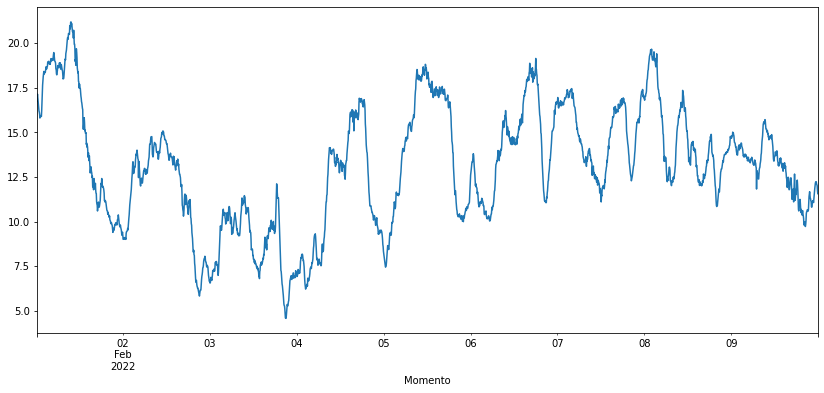

In [ ]:
#%%       VAMOS A LA SERIE 'DEMANDA'

demanda = energia['% Demanda Abastecida'].copy()
demanda.head()
demanda['2022-02-01':'2022-02-09'].plot()


#      apliquemos la prueba de Dickey-Fuller sobre la serie DEMANDA

dickey_fuller(demanda)

# ENTONCES NUESTRA SERIE ES ESTACIONARIA dentro de un umbral de confianza DE 99%


In [ ]:

# ADF Test: Indica la cantidad de diferenciaciones p/ 'estacionarizar' serie

ndiffs(demanda, test = 'adf')

# sale d = 0

0

In [ ]:
#%%   ahora aplicamos ARIMA
# OJO ACÁ: hay varias cosas a prestar atención

demanda.squeeze()  # con esto nos aseguramos que pasamos a Serie

# invocamos el modelo, order = (p, d, q) dice qué tipo de modelo se le pide
# p es el orden del modelo autoregresivo, q el orden del modelo de media móvil
# d: la cantidad de veces q se diferencia la serie para q sea 'débilmente'
# estacionaria
modelo = sm.tsa.arima.model.ARIMA(demanda, order = (2, 0, 1))

resultados = modelo.fit()

pronostico = resultados.fittedvalues
type(pronostico)

#%%
pronostico.head(290)


Momento
2022-02-01 00:05:00    13.487784
2022-02-01 00:10:00    16.723765
2022-02-01 00:15:00    16.747020
2022-02-01 00:20:00    16.983639
2022-02-01 00:25:00    17.205884
                         ...    
2022-02-01 23:50:00     9.340821
2022-02-01 23:55:00     9.416544
2022-02-02 00:00:00     9.201087
2022-02-02 00:05:00     8.969033
2022-02-02 00:10:00     8.995385
Length: 290, dtype: float64

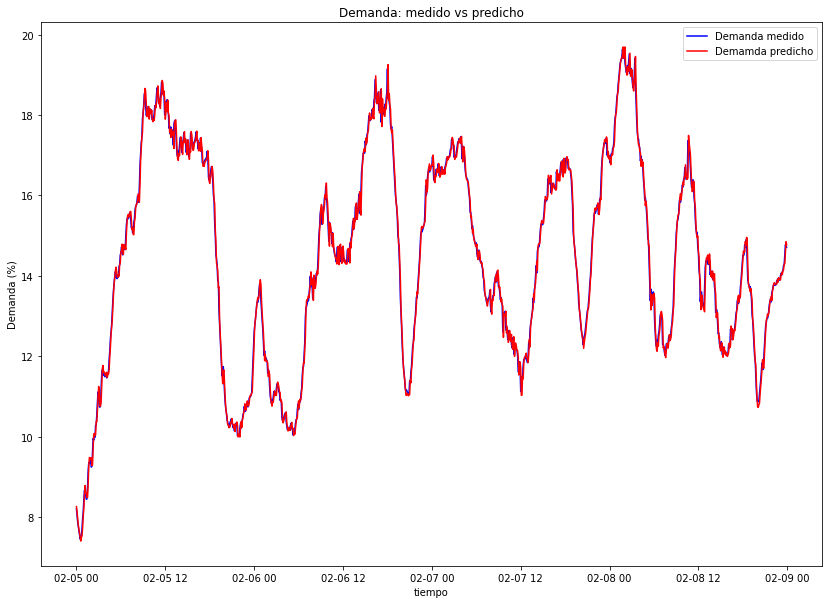

In [ ]:
#%%    graficamos la serie y el ajuste obtenido

plt.figure(figsize = (14, 10))
plt.plot(energia['% Demanda Abastecida']['2022-02-05':'2022-02-08'],
         label= 'Demanda medido',
         color = 'blue')
plt.plot(pronostico['2022-02-05':'2022-02-08'],
         label = 'Demamda predicho',
         color = 'red')
plt.legend(loc = 'best')
plt.xlabel('tiempo')
plt.ylabel('Demanda (%)')
plt.title('Demanda: medido vs predicho')
plt.show()

In [ ]:
print(resultados.summary())   # los parámetros que obtiene el modelo


                                SARIMAX Results                                 
Dep. Variable:     % Demanda Abastecida   No. Observations:                 8064
Model:                   ARIMA(2, 0, 1)   Log Likelihood                1386.278
Date:                  Thu, 16 Mar 2023   AIC                          -2762.555
Time:                          23:26:17   BIC                          -2727.579
Sample:                      02-01-2022   HQIC                         -2750.588
                           - 03-01-2022                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.4878      0.517     26.064      0.000      12.474      14.502
ar.L1          1.9065      0.009    207.491      0.000       1.888       1.924
ar.L2         -0.9076      0.009    

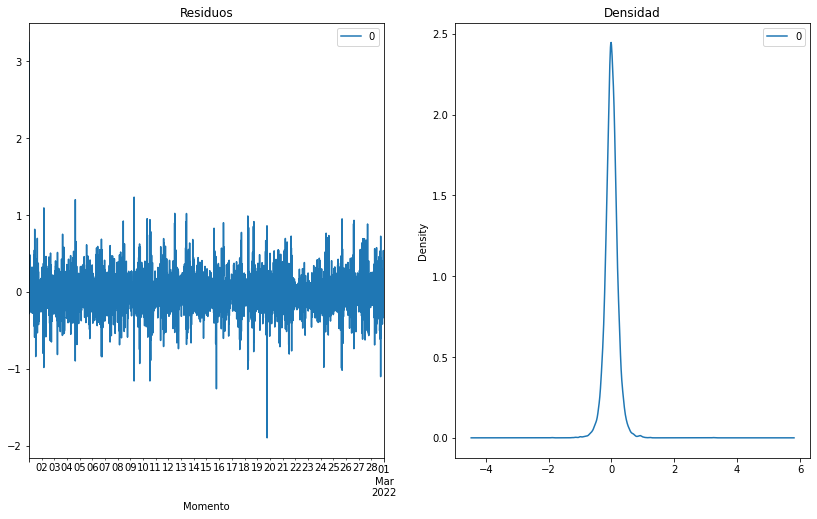

In [ ]:
# Plotear errores residuales, es bueno si están en promedio cerca de 0

residuos = pd.DataFrame(resultados.resid)

rcParams['figure.figsize'] = 14, 8
fig, ax = plt.subplots(1,2)
residuos.plot(title="Residuos", ax=ax[0])
residuos.plot(kind='kde', title='Densidad', ax=ax[1])
plt.show()

In [ ]:
#%% ahora vamos a hacer un pronóstico sobre nuestra serie:
# VALIDACIÓN CRUZADA FUERA DE TIEMPO

# creo cjto de Training y Test, 80% training, 20% testing
# acá no se hace elección aleatoria de las mediciones porque hay que respetar
# el orden temporal

train = demanda[:'2022-02-23 00:00']   # 80% sobre el rango de fechas
test = demanda['2022-02-23 00:05':]

pronosticador = sm.tsa.arima.model.ARIMA(train, order = (2, 0, 1))

resulta = pronosticador.fit()

#%%
print(test.index)


DatetimeIndex(['2022-02-23 00:05:00', '2022-02-23 00:10:00',
               '2022-02-23 00:15:00', '2022-02-23 00:20:00',
               '2022-02-23 00:25:00', '2022-02-23 00:30:00',
               '2022-02-23 00:35:00', '2022-02-23 00:40:00',
               '2022-02-23 00:45:00', '2022-02-23 00:50:00',
               ...
               '2022-02-28 23:15:00', '2022-02-28 23:20:00',
               '2022-02-28 23:25:00', '2022-02-28 23:30:00',
               '2022-02-28 23:35:00', '2022-02-28 23:40:00',
               '2022-02-28 23:45:00', '2022-02-28 23:50:00',
               '2022-02-28 23:55:00', '2022-03-01 00:00:00'],
              dtype='datetime64[ns]', name='Momento', length=1728, freq=None)


In [ ]:
y_pred = resulta.get_forecast(steps = 24*12*6)

conf = y_pred.conf_int(alpha = 0.05)  # 95% de confianza
test.index = pd.date_range(start = '2022-02-23 00:05', end = '2022-03-01',
                           freq = '5T')
y_pred.index = test.index
type(y_pred)

statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper

In [ ]:
pronosticado = y_pred.predicted_mean
pronosticado.index = test.index
abajo = conf['lower % Demanda Abastecida']
arriba = conf['upper % Demanda Abastecida']
#%%
pronosticado.shape
#%%
abajo.shape
#%%
arriba.shape
#%%
pronosticado.head(150)

2022-02-23 00:05:00     8.225360
2022-02-23 00:10:00     8.308294
2022-02-23 00:15:00     8.388936
2022-02-23 00:20:00     8.467410
2022-02-23 00:25:00     8.543828
                         ...    
2022-02-23 12:10:00    12.519922
2022-02-23 12:15:00    12.528306
2022-02-23 12:20:00    12.536571
2022-02-23 12:25:00    12.544719
2022-02-23 12:30:00    12.552752
Freq: 5T, Name: predicted_mean, Length: 150, dtype: float64

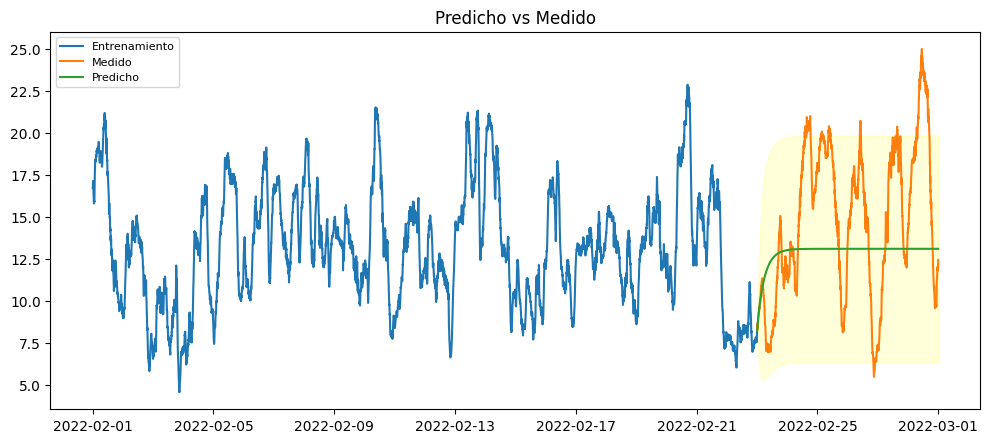

In [ ]:
#%%
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='Entrenamiento')
plt.plot(test, label='Medido')
plt.plot(pronosticado, label='Predicho')
plt.fill_between(abajo.index, abajo, arriba, color='yellow', alpha=.15)
plt.title('Predicho vs Medido')
plt.legend(loc='upper left', fontsize=8)
plt.show()


# MALO, HAY QUE CONSIDERAR QUE LA SERIE TIENE COMPONENTE ESTACIONAL

In [ ]:
demanda.mean()   # 13.486061507936508

13.486061507936508

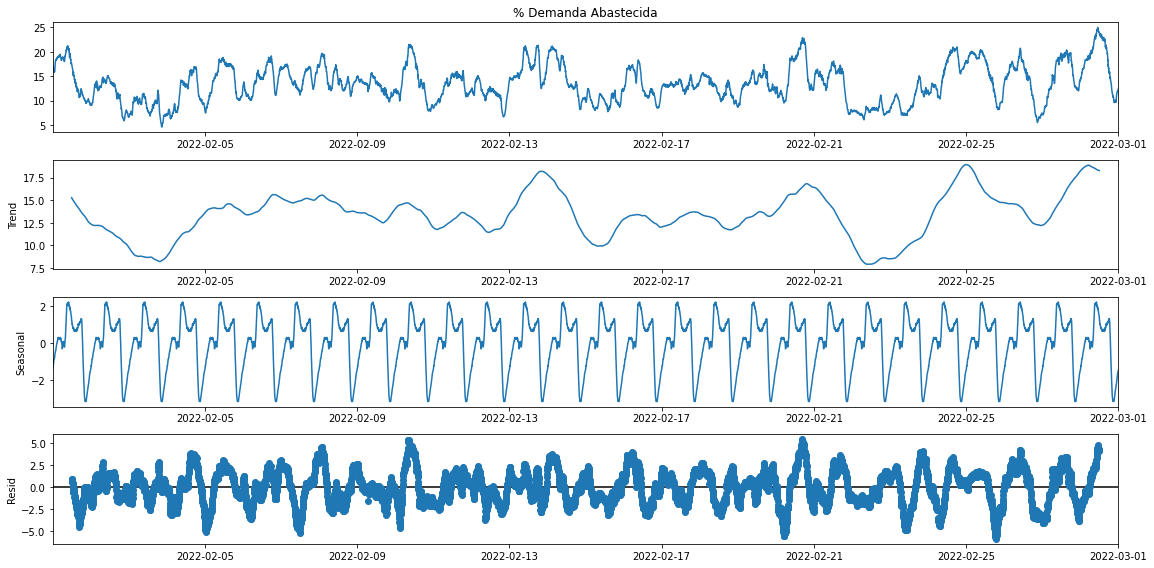

In [ ]:
#%%    HAGAMOS UNA DESCOMPOSICIÓN ESTACIONAL PARA 'DEMANDA'

descomposicion = sm_api.tsa.seasonal_decompose(demanda, model = 'additive',
                                               period = 1*24*12,
                                               two_sided = True )
#%%
type(descomposicion)
residuos = descomposicion.resid
type(residuos)
rcParams['figure.figsize'] = 16, 8
fig = descomposicion.plot()

plt.savefig('descomposicion.png', dpi = 300)


In [ ]:
traindem = demanda[:'2022-02-23 00:00']   # 80% sobre el rango de fechas
testdem = demanda['2022-02-23 00:05':]

In [ ]:
#%%     Y AHORA LA BALA DE PLATA: TBATS    DEMORA 6 MINUTOS

estimador_dem = TBATS(seasonal_periods = [288, 2016],
                      use_arma_errors = False,
                      use_box_cox = False)

# acá tenemos dos componentes estacionales: uno diario y otro semanal
# m es la cantidad de mediciones en un periodo: 1 día = 1*24 h* 12 mediciones/h
#
mod_tbats = estimador_dem.fit(traindem)

pron_tbats = mod_tbats.forecast(steps = 1728)  # 6 días = 6*24*12

tbatsdem = pd.Series(pron_tbats)
tbatsdem.index = testdem.index  # le ponemos las fechas de medición como índice


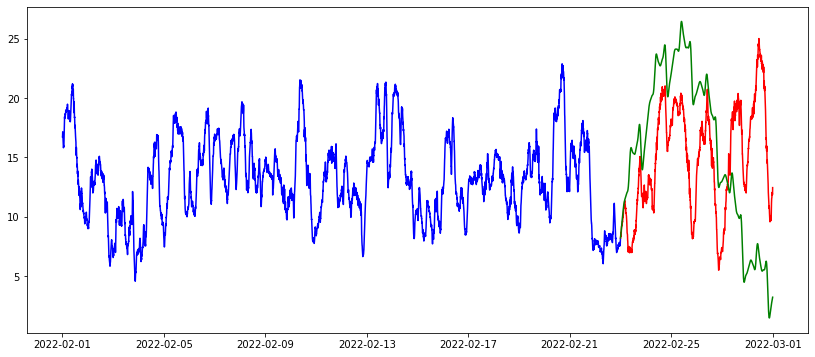

In [ ]:
rcParams['figure.figsize'] = 14, 6
plt.plot(traindem, c = 'blue', label = 'Train')
plt.plot(testdem, c = 'red', label = 'Test')
plt.plot(tbatsdem, c = 'green', label = 'Pronóstico')
plt.show()


In [ ]:
#%%   MIREMOS LOS RESULTADOS DEL MODELO

print(mod_tbats.summary())
# Time series analysis
print(mod_tbats.y_hat) # in sample prediction
print(mod_tbats.resid) # in sample residuals
print(mod_tbats.aic)

# Reading model parameters
print(mod_tbats.params.alpha)
print(mod_tbats.params.beta)
print(mod_tbats.params.x0)
print(mod_tbats.params.components.use_box_cox)
print(mod_tbats.params.components.seasonal_harmonics)

# EL RESULTADO NO ES PERFECTO PORQUE ESTA VARIABLE DEPENDE DE OTRAS SITUACIONES
# EXÓGENAS QUE NO SE PUEDEN CONTEMPLAR ACÁ, PERO ES UNA MEJORA NOTABLE

Use Box-Cox: False
Use trend: True
Use damped trend: True
Seasonal periods: [ 288. 2016.]
Seasonal harmonics [8 1]
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): 1.022438
Trend (Beta): 0.132794
Damping Parameter (Phi): 0.876554
Seasonal Parameters (Gamma): [-7.51151263e-08  3.88159209e-07 -3.71924289e-07 -3.63350454e-07]
AR coefficients []
MA coefficients []
Seed vector [ 2.83307703e+01 -3.93718655e-01 -1.67330124e+00 -2.45787266e-01
  1.63373272e-01  1.98621516e-01  1.84014798e-01 -2.34554439e-01
 -1.09353409e-01  8.10452960e-02  4.59754284e-01  4.33857750e-01
  9.02500435e-01 -2.85830398e-01 -2.77704843e-01 -3.47560750e-02
  1.31824056e-02  8.32717250e-02 -9.47318514e+00  1.90533986e+00]

AIC 35140.377688
[16.87652799 16.45837353 16.56249346 ...  7.60957351  7.80486009
  8.08216499]
[-0.14652799  0.29162647  0.38750654 ...  0.14042649  0.19513991
  0.05783501]
35140.37768848511
1.022438243422541
0.13279416413828127
[ 2.83307703e+01 -3.93718655e-01 -1.67330124e+00 -2.45787266e-01
  1.6

<Axes: xlabel='Momento'>

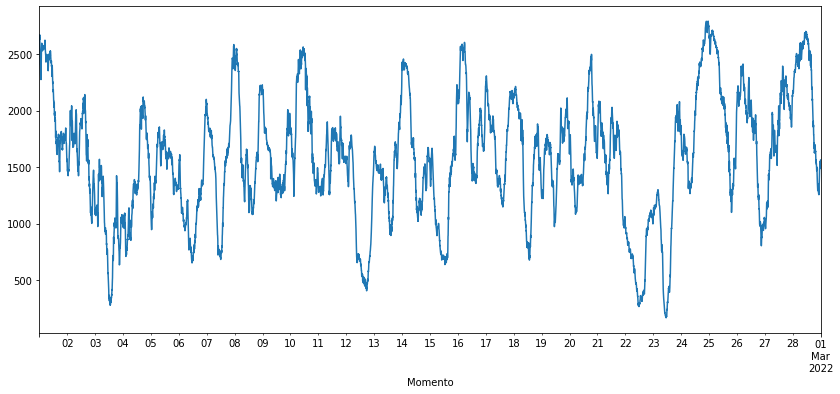

In [ ]:
# veamos los vientos...
viento=energia['Eólico']
viento.plot()

In [ ]:
dickey_fuller(viento)



Resultado de la prueba Dickey-Fuller
------------------
Estadística de prueba	 -5.882234842863424
p-value			 3.059180369365621e-07
------------------
Valores críticos (la estadística de prueba debe ser MENOR)
Confianza 90%		-2.566961339130965 > -5.882234842863424... PASA: ES ESTACIONARIA
Confianza 95%		-2.861899466190631 > -5.882234842863424... PASA: ES ESTACIONARIA
Confianza 99%		-3.4311634031982003 > -5.882234842863424... PASA: ES ESTACIONARIA


In [ ]:
estimadorV = TBATS(seasonal_periods = [288],
                  use_arma_errors = False,
                  use_box_cox = False)
# m es la cantidad de mediciones en un periodo: 1 día = 1*24 h* 12 mediciones/h

tbatsV = estimadorV.fit(train)

pronosticoV = tbatsV.forecast(steps = 1728)  # 6 días = 6*24*12
tbatsWind = pd.Series(pronosticoV)
tbatsWind.index = test.index    # le ponemos las fechas de medición como índice


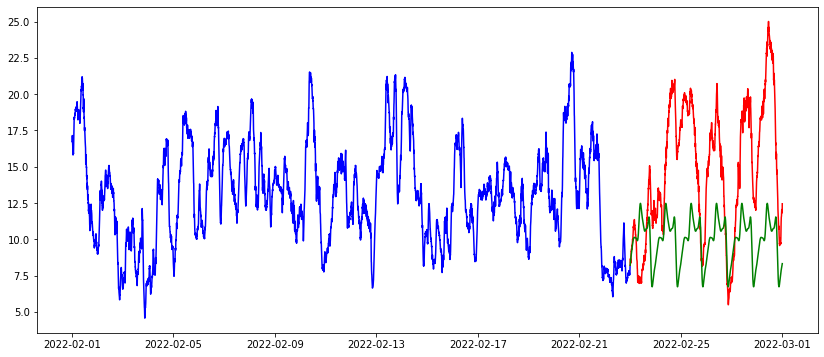

In [ ]:
rcParams['figure.figsize'] = 14, 6
plt.plot(train, c = 'blue', label = 'Train')
plt.plot(test, c = 'red', label = 'Test')
plt.plot(tbatsWind, c = 'green', label = 'Pronóstico')
plt.show()

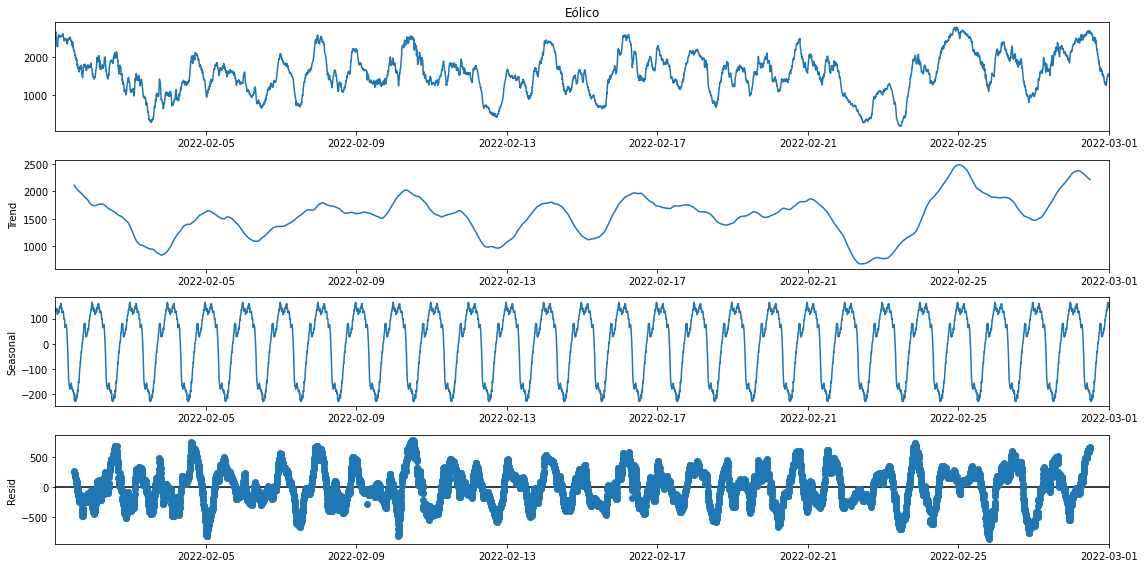

In [ ]:
descV = seasonal_decompose(viento, model = 'additive',period = 1*24*12,two_sided = True )

residuosV = descV.resid
rcParams['figure.figsize'] = 16, 8
fig = descV.plot()